# Compute and Analyze Classifier Metrics

The snakemake pipeline output the probability of 0 / 1 for each cell for each classifier. Here, we compute and save many common metrics from these probabilities. Here we analyze the classification results of each allele.

In [7]:
# imports
import os
import polars as pl
import pandas as pd
import numpy as np
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from plot_utils import *

%matplotlib inline
## Disable truncation globally
# pl.Config.set_tbl_rows(20)  # Show all rows
# pl.Config.set_tbl_cols(40)  # Show all columns

## define control types
TC = ["EGFP"]
NC = ["RHEB", "MAPK9", "PRKACB", "SLIRP"]
PC = ["ALK", "ALK_Arg1275Gln", "PTK2B"]
cNC = ["Renilla"]
cPC = ["KRAS", "PTK2B", "GHSR", "ABL1", "BRD4", "OPRM1", "RB1", "ADA", "WT PMP22", "LYN", "TNF", 
       "CYP2A6", "CSK", "PAK1", "ALDH2", "CHRM3", "KCNQ2", "ALK T1151M", "PRKCE", "LPAR1", "PLP1"]

PLATEMAP_DIR = "../../../1_inputs/1_snakemake_pipeline/inputs/metadata/platemaps/{batch_id}/platemap"
IMGS_QC_DIR = "../../../3_outputs/1_snakemake_pipeline/1.image_well_qc_results" ## plate_bg_summary
CLASS_RES_DIR = "../../../3_outputs/1_snakemake_pipeline/2.sm_pipeline_outputs/classification_results"

TRN_IMBAL_THRES = 3
MIN_CLASS_NUM = 2
CELL_CHANGES = ["localization", "morphology"]

In [2]:
BIO_REP_BATCHES = ["2025_01_27_Batch_13", "2025_01_28_Batch_14"]
COMBINED_BIO_REP_DIR = "2025_01_Batch_13-14"

IMG_QC_DIR = f"../../../3_outputs/1_snakemake_pipeline/pipeline_results_analyses/1.image_well_qc_results/{COMBINED_BIO_REP_DIR}"
OUTPUT_DIR = f"../../../3_outputs/1_snakemake_pipeline/pipeline_results_analyses/3.classification_analyses/{COMBINED_BIO_REP_DIR}"
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

## 1. Metadata

In [6]:
allele_meta_dict = {}
for batch_id in BIO_REP_BATCHES:
    allele_meta_df = pl.DataFrame()
    for platemap in os.listdir(PLATEMAP_DIR.format(batch_id=batch_id)):
        platemap_df = pl.read_csv(os.path.join(PLATEMAP_DIR.format(batch_id=batch_id), platemap), separator="\t", infer_schema_length=100000)
        allele_meta_df = pl.concat([allele_meta_df, 
                                    platemap_df.filter((pl.col("node_type").is_not_null()))], # (~pl.col("node_type").is_in(["TC","NC","PC"]))&
                                    how="diagonal_relaxed").sort("plate_map_name")
        allele_meta_df = allele_meta_df.with_columns(pl.col("plate_map_name").str.split('_').list.get(0).alias("plate_map"))
    allele_meta_dict[batch_id] = allele_meta_df

In [15]:
class_info_dir = "{}/{}/profiles_tcdropped_filtered_var_mad_outlier_featselect_filtcells/classifier_info.csv"

for batch_id in BIO_REP_BATCHES:
    class_res_df = pl.read_csv(class_info_dir.format(CLASS_RES_DIR, batch_id))
    display(class_res_df)
    print(class_res_df["Classifier_ID"][0])

Classifier_ID,Plate,trainsize_0,testsize_0,well_0,allele_0,trainsize_1,testsize_1,well_1,allele_1,Metadata_Control
str,str,i64,i64,str,str,i64,i64,str,str,bool
"""2025_01_27_B13A7A8P1_T1_G08_G0…","""2025_01_27_B13A7A8P1_T1""",508,140,"""G08""","""ALK""",898,364,"""G07""","""ALK""",true
"""2025_01_27_B13A7A8P1_T4_G08_G0…","""2025_01_27_B13A7A8P1_T4""",501,147,"""G08""","""ALK""",852,410,"""G07""","""ALK""",true
"""2025_01_27_B13A7A8P1_T3_G08_G0…","""2025_01_27_B13A7A8P1_T3""",509,139,"""G08""","""ALK""",942,320,"""G07""","""ALK""",true
"""2025_01_27_B13A7A8P1_T2_G08_G0…","""2025_01_27_B13A7A8P1_T2""",426,222,"""G08""","""ALK""",1094,168,"""G07""","""ALK""",true
"""2025_01_27_B13A7A8P1_T1_H07_G0…","""2025_01_27_B13A7A8P1_T1""",200,161,"""H07""","""ALK""",898,364,"""G07""","""ALK""",true
…,…,…,…,…,…,…,…,…,…,…
"""2025_01_27_B13A7A8P2_T4_O06_I0…","""2025_01_27_B13A7A8P2_T4""",866,297,"""O06""","""ZC4H2_Val63Leu""",1194,323,"""I06""","""ZC4H2""",false
"""2025_01_27_B13A7A8P2_T2_M06_I0…","""2025_01_27_B13A7A8P2_T2""",1046,241,"""M06""","""ZC4H2_Val63Leu""",1178,339,"""I06""","""ZC4H2""",false
"""2025_01_27_B13A7A8P2_T3_M06_I0…","""2025_01_27_B13A7A8P2_T3""",864,423,"""M06""","""ZC4H2_Val63Leu""",1003,514,"""I06""","""ZC4H2""",false


2025_01_27_B13A7A8P1_T1_G08_G07


Classifier_ID,Plate,trainsize_0,testsize_0,well_0,allele_0,trainsize_1,testsize_1,well_1,allele_1,Metadata_Control
str,str,i64,i64,str,str,i64,i64,str,str,bool
"""2025_01_28_B14A7A8P1_T2_G08_G0…","""2025_01_28_B14A7A8P1_T2""",277,117,"""G08""","""ALK""",1136,375,"""G07""","""ALK""",true
"""2025_01_28_B14A7A8P1_T4_G08_G0…","""2025_01_28_B14A7A8P1_T4""",298,96,"""G08""","""ALK""",1112,399,"""G07""","""ALK""",true
"""2025_01_28_B14A7A8P1_T1_G08_G0…","""2025_01_28_B14A7A8P1_T1""",334,60,"""G08""","""ALK""",1169,342,"""G07""","""ALK""",true
"""2025_01_28_B14A7A8P1_T3_G08_G0…","""2025_01_28_B14A7A8P1_T3""",273,121,"""G08""","""ALK""",1116,395,"""G07""","""ALK""",true
"""2025_01_28_B14A7A8P1_T2_H07_G0…","""2025_01_28_B14A7A8P1_T2""",223,103,"""H07""","""ALK""",1136,375,"""G07""","""ALK""",true
…,…,…,…,…,…,…,…,…,…,…
"""2025_01_28_B14A7A8P2_T4_O06_I0…","""2025_01_28_B14A7A8P2_T4""",528,228,"""O06""","""ZC4H2_Val63Leu""",982,282,"""I06""","""ZC4H2""",false
"""2025_01_28_B14A7A8P2_T3_M06_I0…","""2025_01_28_B14A7A8P2_T3""",739,364,"""M06""","""ZC4H2_Val63Leu""",924,340,"""I06""","""ZC4H2""",false
"""2025_01_28_B14A7A8P2_T2_M06_I0…","""2025_01_28_B14A7A8P2_T2""",806,297,"""M06""","""ZC4H2_Val63Leu""",877,387,"""I06""","""ZC4H2""",false


2025_01_28_B14A7A8P1_T2_G08_G07


## 2. Classification metrics

### 2.1 Analyze the metrics per each classifier:

Each tested allele should have 2 (protein mislocalization & morphology) * 4 (technical replicates) = 8 classifiers per each batch.

In [14]:
metrics_files = [
    f"../../../8.2_updated_snakemake_pipeline/outputs/classification_analyses/{batch_id}/profiles_tcdropped_filtered_var_mad_outlier_featselect_filtcells/metrics.csv" \
    for batch_id in BIO_REP_BATCHES
]
metric_df_dict = {}

for metric_file in metrics_files:
    metrics_df = pl.read_csv(metric_file)
    batch_id = [subdir for subdir in metric_file.split("/") if "Batch" in subdir][0]
    batch_id = f"B{batch_id.split('Batch_')[-1]}"

    print(f"====================================={batch_id} metrics=====================================")

    metrics_df = metrics_df.with_columns(
        pl.when(pl.col("Metadata_Control"))
        .then(pl.lit("1_Ctrl"))
        .otherwise(pl.lit("2_VAR-WT"))
        .alias("Node_Type"),
        pl.when(pl.col("Full_Classifier_ID").str.contains("true"))
        .then(pl.lit("localization"))
        .otherwise(pl.lit("morphology"))
        .alias("Classifier_type"),
        # Extract the substring that:
        #  1. Has a digit (\d) immediately before it (anchors the match at a number)
        #  2. Starts with 'A' and then as few characters as needed (A.*?), captured as group 1
        #  3. Stops right before the literal 'T'
        pl.col("Plate").str.extract(r"\d(A.*?)T", 1).alias("Allele_set"),
        pl.col("Full_Classifier_ID").str.split("_").list.last().alias("Batch")
    )
    metrics_ctrl_df = metrics_df.filter(
        (pl.col("Training_imbalance") < TRN_IMBAL_THRES) & (pl.col("Metadata_Control"))
    )
    # Filter based on class imbalance
    metrics_ctrl = (
        metrics_ctrl_df
        .select(["Classifier_type", "Batch", "AUROC"])
        .group_by(["Classifier_type", "Batch"])
        .agg([
            pl.col("AUROC").quantile(0.99).alias("AUROC_thresh"),
            pl.col("AUROC").mean().alias("AUROC_mean"),
            pl.col("AUROC").std().alias("AUROC_std")
        ])
    )
    display(metrics_ctrl_df.filter(pl.col("AUROC")>0.7))
    print("Total number of control classifiers:", metrics_ctrl_df.filter((pl.col("Classifier_type") == "localization")).shape[0])
    print("==========================================================================")

    metric_df_dict[f"{batch_id}_met"] = metrics_df

    # Merge with metrics_df and decide whether it passed the threshold
    metrics_df_thres = metrics_df.join(metrics_ctrl, on=["Classifier_type", "Batch"])
    # print(metrics_df_thres.head())

    metrics_df_thres = metrics_df_thres.with_columns(
        ((pl.col("AUROC") - pl.col("AUROC_mean")) / pl.col("AUROC_std")).alias("AUROC_zscore")
    )

    # Must be at least min_class_num classifiers per batch
    # Number of classifiers is the same for localization and morph, so just use morph
    classifier_count = (
        metrics_df_thres.filter(
            (~pl.col("Metadata_Control"))
            & (pl.col("Classifier_type") == "localization")
        )
        .group_by(["allele_0", "Allele_set", "Batch", "allele_1"])
        .agg([pl.len().alias("Number_classifiers")])
    )
    classifier_count = classifier_count.pivot(
        index=["allele_0", "allele_1", "Allele_set"],
        on="Batch",
        values="Number_classifiers",
    )
    print("Total number of unique classifiers:", classifier_count.shape[0])
    print("Total number of unique variant alleles:", len(classifier_count.select("allele_0").to_series().unique().to_list()))
    print("Total number of unique WT genes:", len(classifier_count.select("allele_1").to_series().unique().to_list()))
    print("==========================================================================")

    # Must be at least min_class_num classifiers per batch
    # Number of classifiers is the same for localization and morph, so just use morph
    classifier_count = (
        metrics_df_thres.filter(
            (pl.col("Training_imbalance") < TRN_IMBAL_THRES)
            & (~pl.col("Metadata_Control"))
            & (pl.col("Classifier_type") == "localization")
        )
        .group_by(["allele_0", "Allele_set", "Batch", "allele_1"])
        .agg([pl.len().alias("Number_classifiers")])
    )
    classifier_count = classifier_count.pivot(
        index=["allele_0", "allele_1", "Allele_set"],
        on="Batch",
        values="Number_classifiers",
    )
    print("After filtering out classifiers with training imbalance > 3:")
    print("Total number of unique classifiers:", classifier_count.shape)
    print("Total number of unique variant alleles:", len(classifier_count.select("allele_0").to_series().unique().to_list()))
    print("Total number of unique WT genes:", len(classifier_count.select("allele_1").to_series().unique().to_list()))
    print("==========================================================================")

    classifier_count = classifier_count.filter(
        (pl.col(batch_id) >= MIN_CLASS_NUM)
    )
    print("After filtering out alleles with available number of classifiers < 2:")
    print("Total number of unique classifiers:", classifier_count.shape)
    print("Total number of unique variant alleles:", len(classifier_count.select("allele_0").to_series().unique().to_list()))
    print("Total number of unique WT genes:", len(classifier_count.select("allele_1").to_series().unique().to_list()))

    # filter based on this
    keep_alleles = classifier_count.select("allele_0").to_series().unique().to_list()
    metrics_df_thres = metrics_df_thres.filter(
        ~((~pl.col("Metadata_Control")) & ~pl.col("allele_0").is_in(keep_alleles))
    )

    # Filter by imbalance and calculate mean AUROC for each batch
    metrics_wtvar = (
        (
            metrics_df_thres.filter(
                (pl.col("Training_imbalance") < TRN_IMBAL_THRES) & (~pl.col("Metadata_Control"))
            )
        )
        .select([
            "AUROC",
            "AUROC_zscore",
            "Classifier_type",
            "Batch",
            "AUROC_thresh",
            "allele_0",
            "trainsize_0",
            "testsize_0",
            "trainsize_1",
            "testsize_1",
            "Allele_set",
            "Training_imbalance",
        ])
        .group_by(["Classifier_type", "allele_0", "Allele_set", "Batch", "AUROC_thresh"])
        .agg([
            pl.all()
            .exclude(["Classifier_type", "allele_0", "Allele_set", "Batch", "AUROC_thresh"])
            .mean()
            .name.suffix("_mean")
        ])
    )

    metric_df_dict[f"{batch_id}_met_thres"] = metrics_df_thres
    metric_df_dict[f"{batch_id}_allele_summary"] = metrics_wtvar

=====================================B15 metrics=====================================


AUROC,AUPRC,AUBPRC,Macro_F1,Sensitivity,Specificity,Balanced_Accuracy,Classifier_ID,Full_Classifier_ID,Plate,trainsize_0,testsize_0,well_0,allele_0,trainsize_1,testsize_1,well_1,allele_1,Metadata_Control,train_prob_1,test_prob_1,Training_imbalance,Testing_imbalance,Node_Type,Classifier_type,Allele_set,Batch
f64,f64,f64,f64,f64,f64,f64,str,str,str,i64,i64,str,str,i64,i64,str,str,bool,f64,f64,f64,f64,str,str,str,str
0.711998,0.669439,0.7002,0.638496,0.723364,0.56564,0.644502,"""2025-03-17_B15A1A2_P1T3_H18_H1…","""2025-03-17_B15A1A2_P1T3_H18_H1…","""2025-03-17_B15A1A2_P1T3""",1785,617,"""H18""","""SLIRP""",1622,535,"""H17""","""SLIRP""",true,0.476079,0.46441,1.100493,1.153271,"""1_Ctrl""","""morphology""","""A1A2_P1""","""B15"""
0.775005,0.70264,0.77534,0.684402,0.760064,0.635061,0.697563,"""2025-03-17_B15A1A2_P1T4_J16_I1…","""2025-03-17_B15A1A2_P1T4_J16_I1…","""2025-03-17_B15A1A2_P1T4""",2342,907,"""J16""","""RHEB""",2022,621,"""I16""","""RHEB""",true,0.463336,0.406414,1.158259,1.460548,"""1_Ctrl""","""localization""","""A1A2_P1""","""B15"""
0.956069,0.984929,0.962511,0.87574,0.887755,0.909091,0.898423,"""2025-03-17_B15A1A2_P1T3_J10_I1…","""2025-03-17_B15A1A2_P1T3_J10_I1…","""2025-03-17_B15A1A2_P1T3""",251,77,"""J10""","""ALK_Arg1275Gln""",551,196,"""I10""","""ALK_Arg1275Gln""",true,0.687032,0.717949,2.195219,2.545455,"""1_Ctrl""","""morphology""","""A1A2_P1""","""B15"""
0.804497,0.957256,0.792684,0.679817,0.862805,0.553571,0.708188,"""2025-03-17_B15A1A2_P1T1_H08_G0…","""2025-03-17_B15A1A2_P1T1_H08_G0…","""2025-03-17_B15A1A2_P1T1""",499,56,"""H08""","""ALK""",1191,328,"""G07""","""ALK""",true,0.704734,0.854167,2.386774,5.857143,"""1_Ctrl""","""localization""","""A1A2_P1""","""B15"""
0.712773,0.953103,0.716595,0.522683,0.629108,0.679245,0.654177,"""2025-03-17_B15A1A2_P1T4_H07_G0…","""2025-03-17_B15A1A2_P1T4_H07_G0…","""2025-03-17_B15A1A2_P1T4""",797,53,"""H07""","""ALK""",1093,426,"""G07""","""ALK""",true,0.578307,0.889353,1.371393,8.037736,"""1_Ctrl""","""localization""","""A1A2_P1""","""B15"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
0.704599,0.675307,0.7297,0.631363,0.433272,0.83662,0.634946,"""2025-03-17_B15A1A2_P1T1_E20_E1…","""2025-03-17_B15A1A2_P1T1_E20_E1…","""2025-03-17_B15A1A2_P1T1""",1852,710,"""E20""","""PRKACB""",954,547,"""E19""","""PRKACB""",true,0.339986,0.435163,1.9413,1.297989,"""1_Ctrl""","""localization""","""A1A2_P1""","""B15"""
0.703496,0.883427,0.719983,0.619675,0.857143,0.368421,0.612782,"""2025-03-17_B15A1A2_P1T2_J10_I0…","""2025-03-17_B15A1A2_P1T2_J10_I0…","""2025-03-17_B15A1A2_P1T2""",233,95,"""J10""","""ALK_Arg1275Gln""",675,280,"""I09""","""ALK_Arg1275Gln""",true,0.743392,0.746667,2.896996,2.947368,"""1_Ctrl""","""morphology""","""A1A2_P1""","""B15"""
0.850385,0.919121,0.835883,0.771693,0.885154,0.64375,0.764452,"""2025-03-17_B15A1A2_P1T2_H08_G0…","""2025-03-17_B15A1A2_P1T2_H08_G0…","""2025-03-17_B15A1A2_P1T2""",395,160,"""H08""","""ALK""",1162,357,"""G07""","""ALK""",true,0.746307,0.690522,2.941772,2.23125,"""1_Ctrl""","""morphology""","""A1A2_P1""","""B15"""


Total number of control classifiers: 141
Total number of unique classifiers: 228
Total number of unique variant alleles: 228
Total number of unique WT genes: 29
After filtering out classifiers with training imbalance > 3:
Total number of unique classifiers: (215, 4)
Total number of unique variant alleles: 215
Total number of unique WT genes: 29
After filtering out alleles with available number of classifiers < 2:
Total number of unique classifiers: (210, 4)
Total number of unique variant alleles: 210
Total number of unique WT genes: 29
=====================================B16 metrics=====================================


AUROC,AUPRC,AUBPRC,Macro_F1,Sensitivity,Specificity,Balanced_Accuracy,Classifier_ID,Full_Classifier_ID,Plate,trainsize_0,testsize_0,well_0,allele_0,trainsize_1,testsize_1,well_1,allele_1,Metadata_Control,train_prob_1,test_prob_1,Training_imbalance,Testing_imbalance,Node_Type,Classifier_type,Allele_set,Batch
f64,f64,f64,f64,f64,f64,f64,str,str,str,i64,i64,str,str,i64,i64,str,str,bool,f64,f64,f64,f64,str,str,str,str
0.973435,0.941203,0.974308,0.870901,0.732143,0.969012,0.850577,"""2025-03-18_B16A1A2_P1T3_K14_K1…","""2025-03-18_B16A1A2_P1T3_K14_K1…","""2025-03-18_B16A1A2_P1T3""",3367,1194,"""K14""","""MAPK9""",1765,504,"""K13""","""MAPK9""",true,0.34392,0.29682,1.907649,2.369048,"""1_Ctrl""","""morphology""","""A1A2_P1""","""B16"""
0.71866,0.76261,0.748229,0.660049,0.628121,0.694602,0.661362,"""2025-03-18_B16A1A2_P1T4_F20_E1…","""2025-03-18_B16A1A2_P1T4_F20_E1…","""2025-03-18_B16A1A2_P1T4""",2290,704,"""F20""","""PRKACB""",1713,761,"""E19""","""PRKACB""",true,0.427929,0.519454,1.336836,1.080966,"""1_Ctrl""","""morphology""","""A1A2_P1""","""B16"""
0.7325,0.686169,0.748211,0.649505,0.74055,0.582807,0.661678,"""2025-03-18_B16A1A2_P1T2_F20_E1…","""2025-03-18_B16A1A2_P1T2_F20_E1…","""2025-03-18_B16A1A2_P1T2""",2203,791,"""F20""","""PRKACB""",1892,582,"""E19""","""PRKACB""",true,0.462027,0.423889,1.164376,1.359107,"""1_Ctrl""","""morphology""","""A1A2_P1""","""B16"""
0.785083,0.790582,0.788328,0.720166,0.761785,0.679181,0.720483,"""2025-03-18_B16A1A2_P1T2_L13_K1…","""2025-03-18_B16A1A2_P1T2_L13_K1…","""2025-03-18_B16A1A2_P1T2""",2810,1172,"""L13""","""MAPK9""",3373,1188,"""K14""","""MAPK9""",true,0.545528,0.50339,1.200356,1.013652,"""1_Ctrl""","""morphology""","""A1A2_P1""","""B16"""
0.781542,0.590388,0.773479,0.695234,0.678571,0.747906,0.713239,"""2025-03-18_B16A1A2_P1T3_K14_K1…","""2025-03-18_B16A1A2_P1T3_K14_K1…","""2025-03-18_B16A1A2_P1T3""",3367,1194,"""K14""","""MAPK9""",1765,504,"""K13""","""MAPK9""",true,0.34392,0.29682,1.907649,2.369048,"""1_Ctrl""","""localization""","""A1A2_P1""","""B16"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
0.700206,0.679568,0.716397,0.693651,0.651206,0.735202,0.693204,"""2025-03-18_B16A1A2_P1T4_H17_G1…","""2025-03-18_B16A1A2_P1T4_H17_G1…","""2025-03-18_B16A1A2_P1T4""",1891,642,"""H17""","""SLIRP""",1781,539,"""G18""","""SLIRP""",true,0.485022,0.456393,1.061763,1.191095,"""1_Ctrl""","""morphology""","""A1A2_P1""","""B16"""
0.852976,0.817526,0.897328,0.614242,0.845649,0.496633,0.671141,"""2025-03-18_B16A1A2_P1T2_K14_K1…","""2025-03-18_B16A1A2_P1T2_K14_K1…","""2025-03-18_B16A1A2_P1T2""",3373,1188,"""K14""","""MAPK9""",1660,609,"""K13""","""MAPK9""",true,0.329823,0.338898,2.031928,1.950739,"""1_Ctrl""","""morphology""","""A1A2_P1""","""B16"""
0.85207,0.926369,0.847342,0.743679,0.828431,0.666667,0.747549,"""2025-03-18_B16A1A2_P1T4_J10_I1…","""2025-03-18_B16A1A2_P1T4_J10_I1…","""2025-03-18_B16A1A2_P1T4""",419,90,"""J10""","""ALK_Arg1275Gln""",546,204,"""I10""","""ALK_Arg1275Gln""",true,0.565803,0.693878,1.303103,2.266667,"""1_Ctrl""","""morphology""","""A1A2_P1""","""B16"""


Total number of control classifiers: 144
Total number of unique classifiers: 232
Total number of unique variant alleles: 232
Total number of unique WT genes: 29
After filtering out classifiers with training imbalance > 3:
Total number of unique classifiers: (214, 4)
Total number of unique variant alleles: 214
Total number of unique WT genes: 29
After filtering out alleles with available number of classifiers < 2:
Total number of unique classifiers: (214, 4)
Total number of unique variant alleles: 214
Total number of unique WT genes: 29


In [15]:
# metric_df_dict["B11_met_thres"].filter((pl.col("Metadata_Control"))&(pl.col("allele_0")=="MLH1_Ala586Asp")&((pl.col("Full_Classifier_ID").str.contains("true"))))

## 3. Plotting Metrics

In [16]:
def plot_metric_dist(df, value, batch, col="Node_Type", hue="Node_Type"):
    g = sns.displot(
        data=df, 
        x=value, col=col, kde=True, hue=hue, 
        facet_kws={'sharey': False, 'col_order': sorted(df[col].unique())},
        palette="Set2", hue_order=sorted(df[hue].unique()),
        legend=False, height=4, aspect=1.1
    )
    g.fig.suptitle(f"Batch {batch} {value}", fontsize=12, y=1.)
    g.fig.tight_layout()
    g.fig.subplots_adjust(top=0.9)
    g.savefig(
        os.path.join(OUTPUT_DIR, f"B{batch}_{value}_dist.png"),
        dpi=300,
        bbox_inches="tight"
    )

AUROC 99th percentile threshold for localization in 2025_03_17_Batch_15: 0.850
AUROC 99th percentile threshold for morphology in 2025_03_17_Batch_15: 0.971
AUROC 99th percentile threshold for localization in 2025_03_17_Batch_16: 0.775
AUROC 99th percentile threshold for morphology in 2025_03_17_Batch_16: 0.884


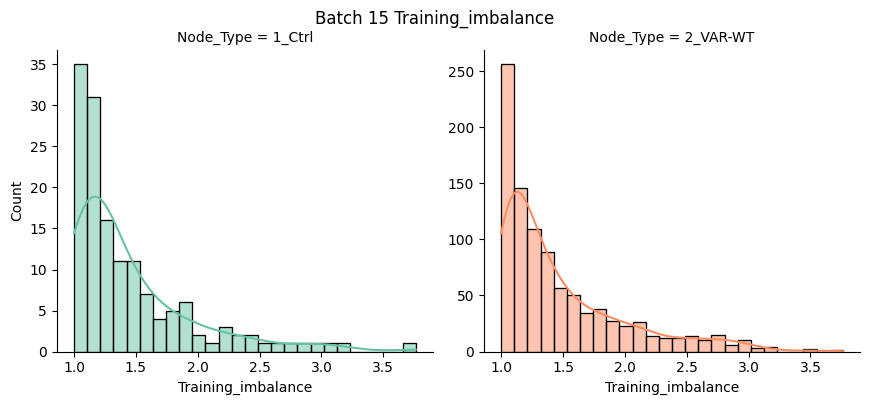

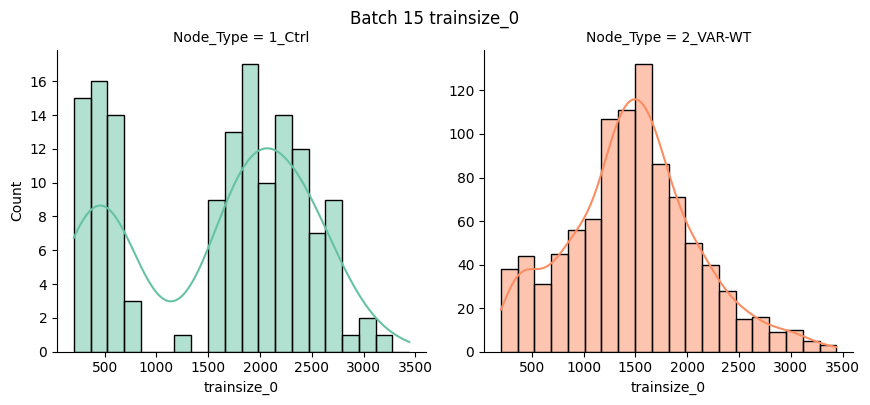

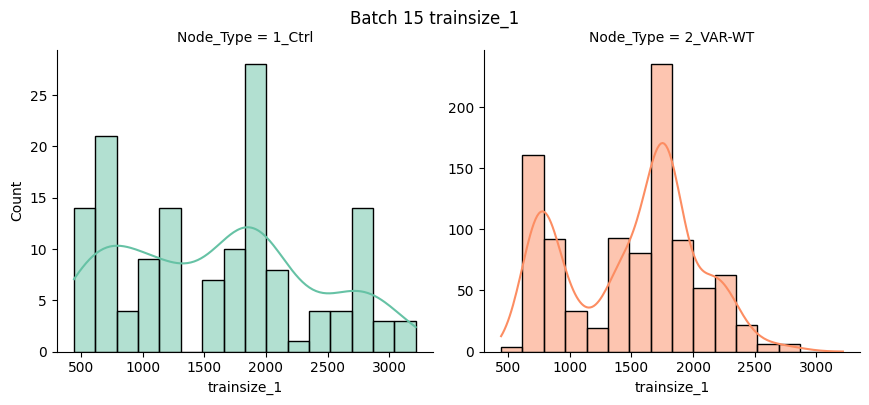

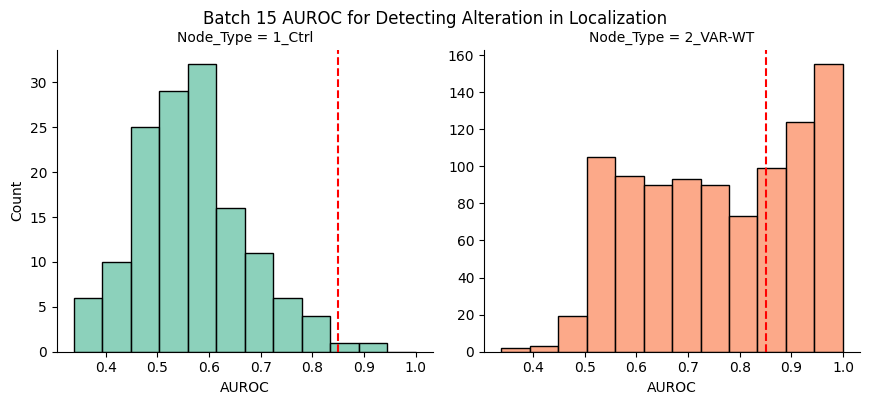

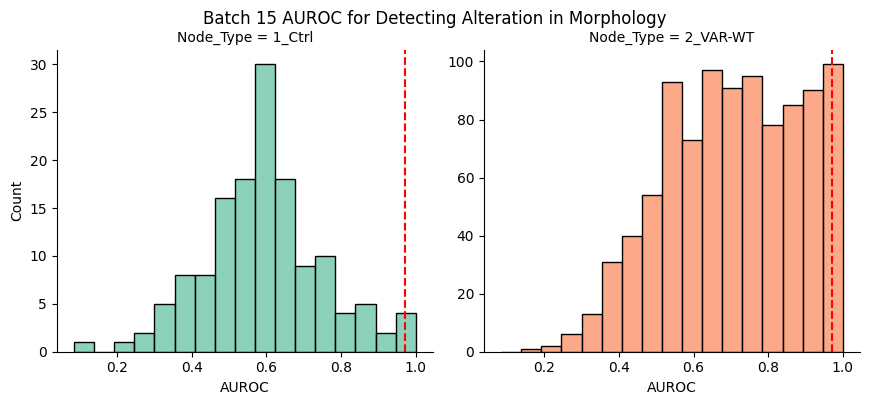

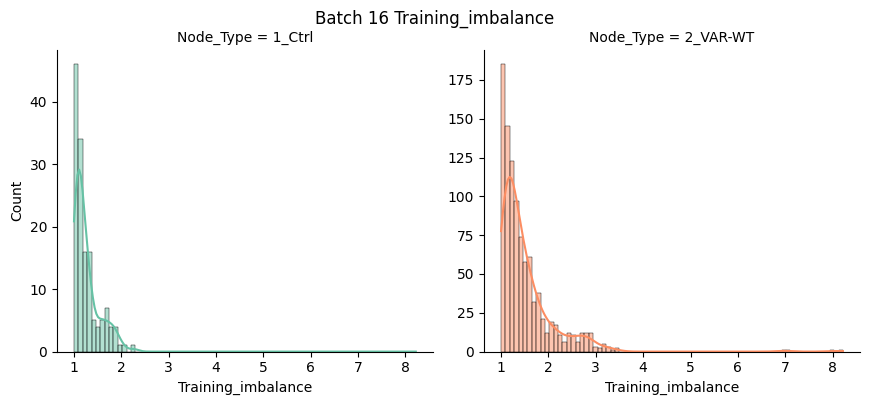

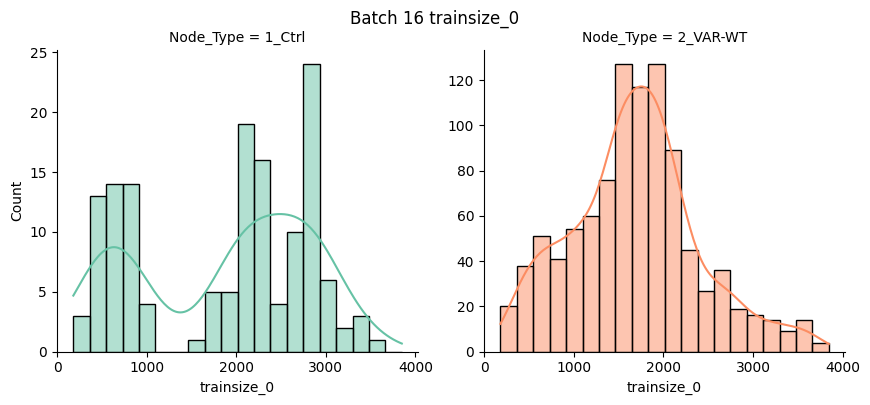

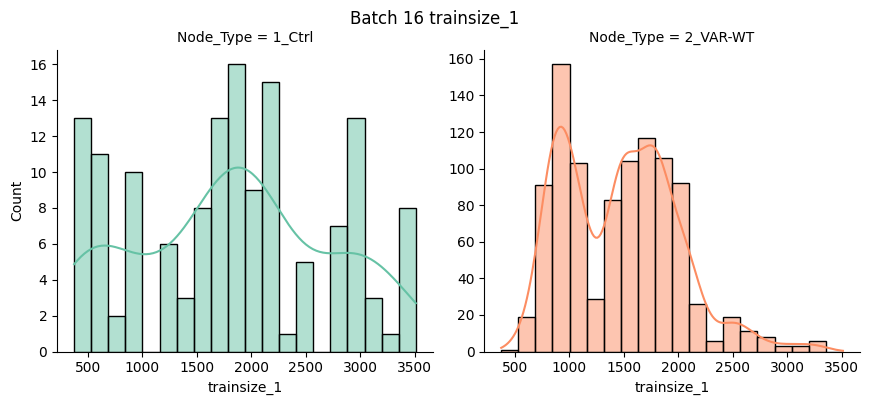

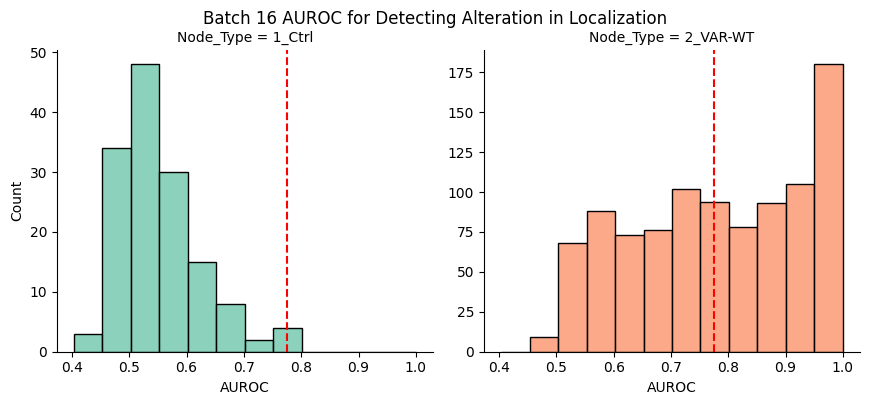

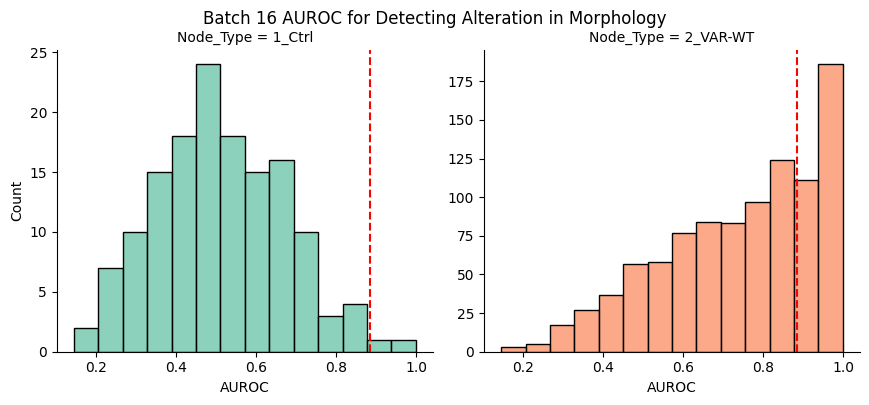

In [17]:
for batch_id in BIO_REP_BATCHES:
    batch_num = batch_id.split("_")[-1]
    for change in CELL_CHANGES:
        ## Only need to plot for one change, since the other is duplicative
        if change == "localization":
            df_local = metric_df_dict[f"B{batch_num}_met_thres"].filter(pl.col("Classifier_type") == change)
            plot_metric_dist(df_local, value="Training_imbalance", batch=batch_num, col="Node_Type")
            plot_metric_dist(df_local, value="trainsize_0", batch=batch_num, col="Node_Type")
            plot_metric_dist(df_local, value="trainsize_1", batch=batch_num, col="Node_Type")

        perc_99 = metric_df_dict[f"B{batch_num}_met_thres"].filter(pl.col("Classifier_type") == change).select("AUROC_thresh").mean().to_numpy()[0][0]
        print(f"AUROC 99th percentile threshold for {change} in {batch_id}: {perc_99:.3f}")

        # Plot with vertical lines
        g = sns.displot(
            data=metric_df_dict[f"B{batch_num}_met_thres"].filter((pl.col("Classifier_type") == change)&(pl.col("Training_imbalance")<TRN_IMBAL_THRES)), 
            x="AUROC", col="Node_Type", kde=False,
            facet_kws={'sharey': False, 'col_order': sorted(metrics_df['Node_Type'].unique())},
            hue="Node_Type", palette="Set2", hue_order=sorted(metrics_df['Node_Type'].unique()),
            legend=False, height=4, aspect=1.1, #log_scale=(False, True)
        )
        ## Add vertical lines and labels
        for ax, node_type in zip(g.axes.flat, sorted(metrics_df['Node_Type'].unique())):
            ax.axvline(perc_99, color='red', linestyle='--')
            # ax.text(perc_99, ax.get_ylim()[1], '99th perc', color='red', ha='center')
        # plt.show()

        g.fig.suptitle(f"Batch {batch_num} AUROC for Detecting Alteration in {change.capitalize()}", fontsize=12, y=1.)
        g.fig.subplots_adjust(top=0.9)
        # g.savefig(
        #     os.path.join(OUTPUT_DIR, f"B{batch_num}_{change}_dist.png"),
        #     dpi=300,
        #     bbox_inches="tight"
        # )

In [18]:
metrics_files = [
    f"../../../8.2_updated_snakemake_pipeline/outputs/classification_analyses/{batch_id}/profiles_tcdropped_filtered_var_mad_outlier_featselect_filtcells/metrics_summary.csv" \
    for batch_id in BIO_REP_BATCHES
]

metric_sum_df_dict = {}
for metric_file in metrics_files:
    metric_sum_df = pl.read_csv(metric_file)

    # Assuming you have a Polars DataFrame named df and you want to rank the values in the 'column_name' column
    metric_sum_df = metric_sum_df.with_columns(
        pl.col('AUROC_mean').rank('dense').alias('AUROC_rank')
    )

    # for classifier in ["morphology", "localization"]:
    #     sns.displot(data=metric_sum_df.filter(pl.col("Classifier_type")==classifier), x="AUROC_mean", kde=True)
        # display(metric_sum_df.filter((pl.col("Classifier_type") == classifier)&(pl.col("AUROC_mean") >= pl.col("AUROC_thresh"))).head())

    metric_sum_df_dict[metric_file.split("/")[-3]] = metric_sum_df

## 3. Correlation between biological replicates

Spearman's correlation: 0.9312639204906189
Spearman's correlation: 0.5138492794805534


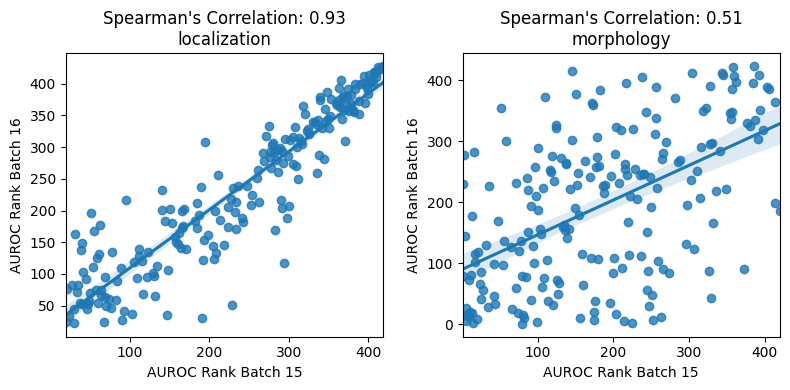

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

fig, axes = plt.subplots(1, 2, figsize=(8,4))
for classifier_type in CELL_CHANGES:
    # Select the columns "allele_0" and "AUROC_rank" from both dataframes
    set1_ranks = metric_sum_df_dict[BIO_REP_BATCHES[0]].filter((pl.col("Classifier_type") == classifier_type)).select(["allele_0", "AUROC_rank"])
    set2_ranks = metric_sum_df_dict[BIO_REP_BATCHES[1]].filter((pl.col("Classifier_type") == classifier_type)).select(["allele_0", "AUROC_rank"])
    # Join the dataframes on the "allele_0" column
    joined_ranks = set1_ranks.join(set2_ranks, on="allele_0", how="inner", suffix="_batch14")
    # Calculate the Spearman's correlation between the ranks
    spearman_corr, _ = spearmanr(joined_ranks["AUROC_rank"], joined_ranks["AUROC_rank_batch14"])
    print(f"Spearman's correlation: {spearman_corr}")

    # Plot the correlation using a regression plot
    sns.regplot(x="AUROC_rank", y="AUROC_rank_batch14", data=joined_ranks.to_pandas(), ax=axes[CELL_CHANGES.index(classifier_type)])
    axes[CELL_CHANGES.index(classifier_type)].set_title(f"Spearman's Correlation: {spearman_corr:.2f}\n{classifier_type}")
    axes[CELL_CHANGES.index(classifier_type)].set_xlabel(f"AUROC Rank Batch {BIO_REP_BATCHES[0].split('_')[-1]}")
    axes[CELL_CHANGES.index(classifier_type)].set_ylabel(f"AUROC Rank Batch {BIO_REP_BATCHES[1].split('_')[-1]}")

plt.tight_layout()
plt.subplots_adjust(wspace=.25)
plt.savefig(
    os.path.join(OUTPUT_DIR, f"AUROC_rank_correlation.png"),
    dpi=300,
    bbox_inches="tight"
)

In [12]:
# set1 = metric_sum_df_dict["2025_01_27_Batch_13"].filter((pl.col("Classifier_type") == "localization")&(pl.col("AUROC_mean") >= pl.col("AUROC_thresh"))).select(pl.col("allele_0"))
# set2 = metric_sum_df_dict["2025_01_28_Batch_14"].filter((pl.col("Classifier_type") == "localization")&(pl.col("AUROC_mean") >= pl.col("AUROC_thresh"))).select(pl.col("allele_0"))

In [13]:
# metrics_df.filter(pl.col("Plate")=="2025-03-17_B15A1A2_P1T1").unique(subset="well_0")#.with_columns(pl.col("well_0").alias("well_po"))#.agg(pl.mean)
# categorical mode (exactly your original behavior):

# for platemap in os.listdir(platemap_dir):
#     platemap_df = pl.read_csv(os.path.join(platemap_dir, platemap), separator="\t")
#     # display(platemap_df)
#     for key, df in metric_df_dict.items():
#         # print(key)
#         if "met_thres" in key:
#             for plate in df["Plate"].unique():
#                 print(plate)
#                 auroc_platemap = platemap_df.with_columns(
#                         pl.concat_str([pl.col("well_position"), pl.col("gene_allele")], separator="_").alias("well_allele")
#                 ).join(
#                     df.filter((pl.col("Plate")==plate)&(pl.col("Metadata_Control"))).unique(subset="well_0").with_columns(
#                         pl.concat_str([pl.col("well_0"), pl.col("allele_0")], separator="_").alias("well_allele")
#                     ),
#                     left_on="well_allele", right_on="well_allele", how="left"
#                 ).filter(pl.col("AUROC").is_not_null())
#                 # display(auroc_platemap)
#                 plot_platemap(
#                     auroc_platemap,
#                     plate_name=plate,
#                     well_pos_col="well_position",
#                     value_col="AUROC",
#                     label_cols=("gene_allele","AUROC"),
#                     value_type="continuous",
#                     continuous_cmap="viridis_r"
#                 )

In [14]:
# metrics_df.filter(pl.col("Plate")=="2025-03-17_B15A1A2_P1T1").unique(subset="well_0")#.with_columns(pl.col("well_0").alias("well_po"))#.agg(pl.mean)
# categorical mode (exactly your original behavior):

# for platemap in os.listdir(platemap_dir):
#     platemap_df = pl.read_csv(os.path.join(platemap_dir, platemap), separator="\t")
#     for key, df in metric_df_dict.items():
#         if "met_thres" in key:
#             for change in CELL_CHANGES:
#                 df_chg = df.filter(pl.col("Classifier_type") == change)
#                 for plate in df_chg["Plate"].unique():
#                     # print(plate)
#                     auroc_platemap = platemap_df.with_columns(
#                             pl.concat_str([pl.col("well_position"), pl.col("gene_allele")], separator="_").alias("well_allele")
#                     ).join(
#                         df_chg.filter((pl.col("Plate")==plate)&(~pl.col("Metadata_Control"))).unique(subset="well_0").with_columns(
#                             pl.concat_str([pl.col("well_0"), pl.col("allele_0")], separator="_").alias("well_allele")
#                         ),
#                         left_on="well_allele", right_on="well_allele", how="left"
#                     ).filter(pl.col("AUROC").is_not_null())
#                     # display(auroc_platemap)
#                     plot_platemap(
#                         auroc_platemap,
#                         plate_name=f"{plate}_{change}",
#                         well_pos_col="well_position",
#                         value_col="AUROC",
#                         label_cols=("gene_allele","AUROC"),
#                         value_type="continuous",
#                         continuous_cmap="viridis_r"
#                     )

## 4. Calling hits

In [18]:
from functools import reduce
import operator

metrics_sum_wtvar = pl.concat(list(metric_sum_df_dict.values()))
# metrics_sum_wtvar

In [19]:
# split into morphology and localization, and count the proportion of classifiers that surpass the 0.99 NULL F1 score
morph_wtvar = metrics_sum_wtvar.filter(pl.col("Classifier_type") == "morphology")
local_wtvar = metrics_sum_wtvar.filter(pl.col("Classifier_type") == "localization")
print(local_wtvar.shape)
print(morph_wtvar.shape)

(878, 12)
(878, 12)


In [20]:
def plot_gene_level_summary(total_allele_hit_sum_df, cell_change):
    # 1. Fill nulls with 0
    total_allele_hit_sum_df["len_hits"] = total_allele_hit_sum_df["len_hits"].fillna(0).astype(int)
    # 2. Compute percentage of hits
    total_allele_hit_sum_df["pct_hits"] = total_allele_hit_sum_df["len_hits"] / total_allele_hit_sum_df["len"] * 100
    # 3. Sort by percentage descending
    total_allele_hit_sum_df = total_allele_hit_sum_df.sort_values(by=["len","pct_hits"], ascending=False).reset_index(drop=True)
    
    x = range(len(total_allele_hit_sum_df))
    n_genes = len(x)

    # 4. Dynamically scale figure size
    bar_width = 0.6
    fig_width = max(8, min(n_genes * 0.6, 40))  # cap size for huge plots
    fig_height = 6
    fig, ax = plt.subplots(figsize=(fig_width, fig_height))

    # Plot bars
    ax.bar(x, total_allele_hit_sum_df["len"], color="skyblue", label="# Variants")
    ax.bar(x, total_allele_hit_sum_df["len_hits"], color="tomato", label="# of Hits")

    # Annotate percentage
    for i, pct in enumerate(total_allele_hit_sum_df["pct_hits"]):
        ax.text(
            i,
            total_allele_hit_sum_df.loc[i, "len"] + 0.5,
            f"{pct:.1f}%",
            ha="center",
            va="bottom",
            fontsize=10 if n_genes > 20 else 11,
            rotation=0,
        )

    # Axis formatting
    ax.set_xticks(x)
    ax.set_xticklabels(
        total_allele_hit_sum_df["by"],
        rotation=45,
        ha="right",
        fontsize=10 if n_genes > 20 else 11,
    )
    ax.set_ylabel("Count", fontsize=11)
    ax.set_title(
        f"Altered {cell_change.capitalize()} Hits per Gene (sorted by % hits)",
        fontsize=13,
    )
    ax.set_ylim(0, total_allele_hit_sum_df["len"].max() * 1.1)
    ax.legend(fontsize=11)

    # Improve spacing
    plt.tight_layout()
    plt.show()

allele_0,Altered_local_batch13,Altered_local_batch14,Altered_local_both_batches,AUROC_batch13,AUROC_batch14,AUROC_Mean
str,i32,i32,bool,f64,f64,f64
"""LMNA_Arg377Leu""",1,1,true,0.998251,0.998218,0.998235
"""CCM2_Arg423Pro""",1,1,true,0.969649,0.955091,0.96237
"""CCM2_Ile425Thr""",1,1,true,0.989914,0.980963,0.985438
"""F9_Trp453Arg""",1,1,true,0.930362,0.964911,0.947636
"""RET_Arg330Gln""",1,1,true,0.919767,0.872985,0.896376
…,…,…,…,…,…,…
"""BRIP1_Thr266Lys""",1,1,true,0.961583,0.94805,0.954817
"""ZC4H2_Leu66His""",1,1,true,0.959374,0.965136,0.962255
"""RPS19_Val15Phe""",1,1,true,0.929978,0.927229,0.928604


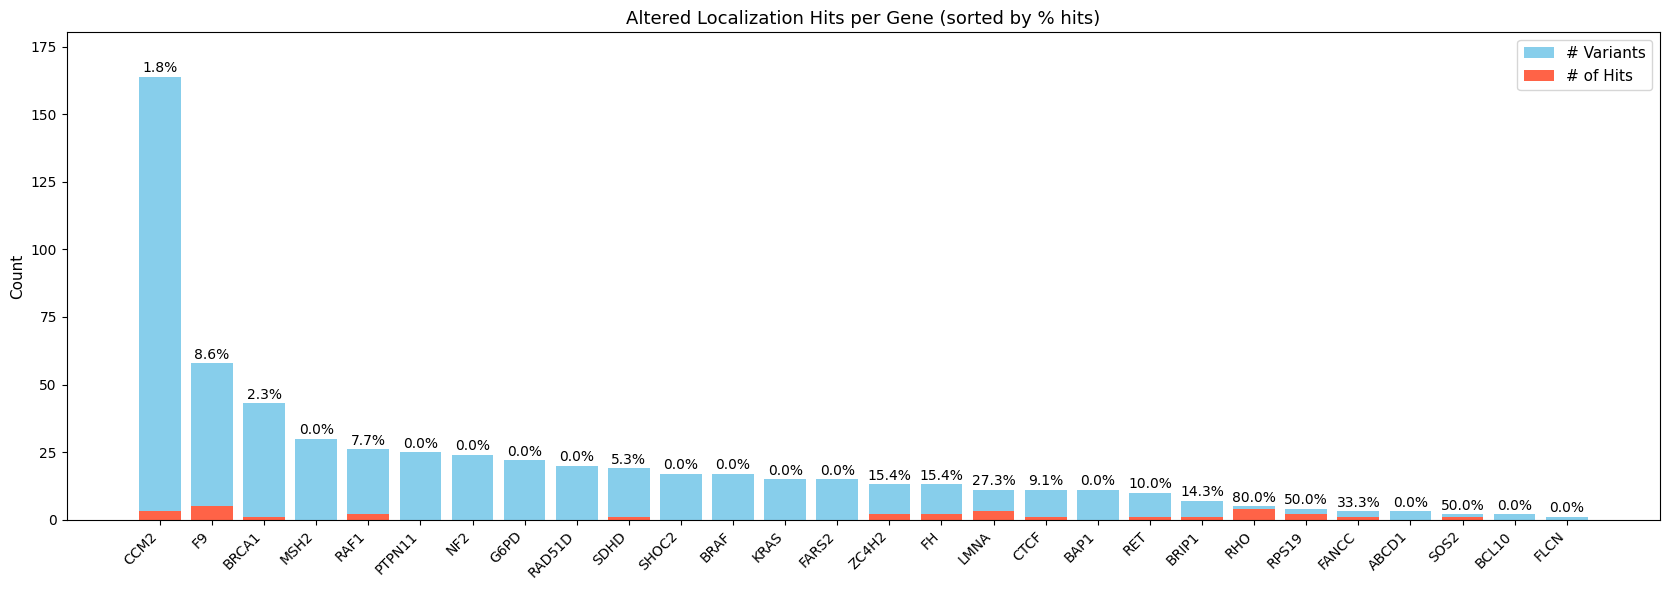

allele_0,Altered_morph_batch13,Altered_morph_batch14,Altered_morph_both_batches,AUROC_batch13,AUROC_batch14,AUROC_Mean
str,i32,i32,bool,f64,f64,f64
"""BRCA1_Phe558Ser""",1,1,true,0.949848,0.985602,0.967725
"""BRCA1_His299Tyr""",1,1,true,0.97526,0.983917,0.979588
"""BRCA1_Asn132Lys""",1,1,true,0.989884,0.979692,0.984788
"""BRCA1_Met548Ile""",1,1,true,0.978572,0.989062,0.983817
"""BRCA1_Arg71Lys""",1,1,true,0.933073,0.979686,0.956379
…,…,…,…,…,…,…
"""BRCA1_Ser186Tyr""",1,1,true,0.989543,0.98914,0.989342
"""BRCA1_Ser611Arg""",1,1,true,0.955394,0.980993,0.968193
"""BRAF_Gly596Val""",1,1,true,0.938111,0.968325,0.953218


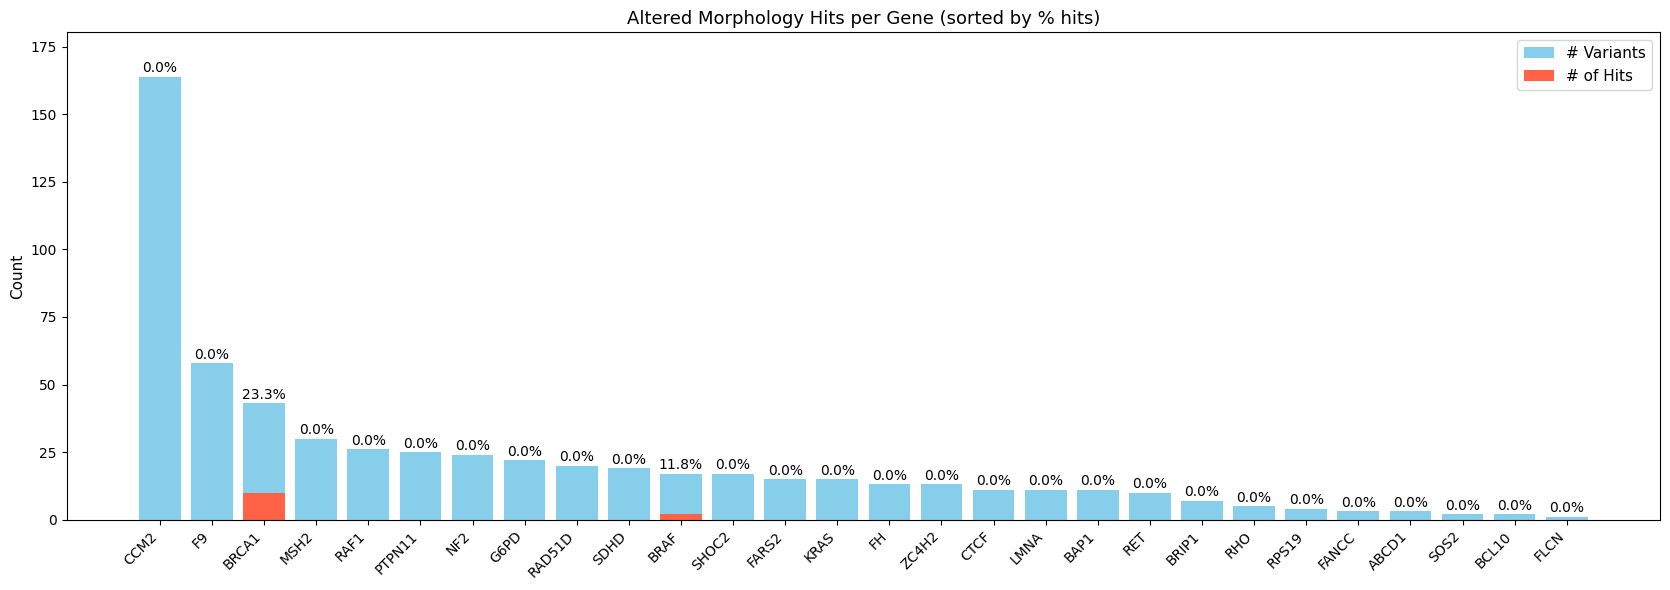

In [21]:
for cell_change in CELL_CHANGES:
    ## Filter the change to detect
    cell_chg_wtvar = metrics_sum_wtvar.filter(pl.col("Classifier_type") == cell_change)
    ## Per each batch, get the hits
    cell_chg_wtvar = cell_chg_wtvar.with_columns(
        pl.when(pl.col("AUROC_mean") > pl.col("AUROC_thresh"))
        .then(1)
        .otherwise(0)
        .alias(f"Altered_{cell_change[:5]}")
    ).unique()
    # print(cell_chg_wtvar.filter(pl.col("allele_0")=="DES_Asp343Asn"))
    # break
    ## Per combine the hits from both batches
    change_binary = (
        cell_chg_wtvar.pivot(
            index=["allele_0"], ## , "Allele_set"
            on="Batch",
            values=f"Altered_{cell_change[:5]}",
        )
        # 1) rename each pivoted batch-column
        .rename({f"B{batch.split('_')[-1]}": f"Altered_{cell_change[:5]}_batch{batch.split('_')[-1]}" for batch in BIO_REP_BATCHES})
        # 2) add the “both” column by AND-reducing all of them
        .with_columns(
            reduce(
                operator.and_,
                [pl.col(f"Altered_{cell_change[:5]}_batch{batch.split('_')[-1]}") == 1 for batch in BIO_REP_BATCHES]
            ).alias(f"Altered_{cell_change[:5]}_both_batches")
        )
    )
    ## Per combine the AUROC scores from both batches
    change_auroc = cell_chg_wtvar.pivot(
        index=["allele_0"],
        on="Batch",
        values="AUROC_mean",
    ).rename(
        {f"B{batch.split('_')[-1]}": f"AUROC_batch{batch.split('_')[-1]}" for batch in BIO_REP_BATCHES}
    ).with_columns(
        (
            reduce(
                operator.add,
                [
                    pl.col(f"AUROC_batch{batch.split('_')[-1]}")
                    for batch in BIO_REP_BATCHES
                ]
            )
            / len(BIO_REP_BATCHES)
        ).alias("AUROC_Mean")
    )
    change_summary = change_binary.join(change_auroc, on="allele_0")
    # display(change_summary)
    display(change_summary.filter(pl.col(f"Altered_{cell_change[:5]}_both_batches")))

    # platemap_df
    total_allele_hit_sum_df = total_allele_df.filter(pl.col("node_type")=="allele").unique(subset="gene_allele").group_by(by="symbol").len().sort(by="len", descending=True).join(
        change_summary.filter(pl.col(f"Altered_{cell_change[:5]}_both_batches")).with_columns(
        pl.col("allele_0").str.extract(r"^([^_]+)", 1).alias("symbol")
    ).group_by(by="symbol").len().sort(by="len", descending=True), on="by", suffix="_hits", how="left").to_pandas()

    plot_gene_level_summary(total_allele_hit_sum_df, cell_change)

    change_summary.write_csv(f"{OUTPUT_DIR}/altered_{cell_change[:5]}_summary_auroc.csv")

## 5. ClinVar

In [24]:
var_scores = pl.read_csv("/home/shenrunx/igvf/varchamp/2025_laval_submitted/3_integrated_assay_results/1_inputs/ai_pred_struc_scores.tsv", 
                         separator="\t", infer_schema_length=10000)
var_scores = var_scores.with_columns(
    pl.concat_str([pl.col("symbol"), pl.col("aa_change")], separator="_").alias("allele_0")
)

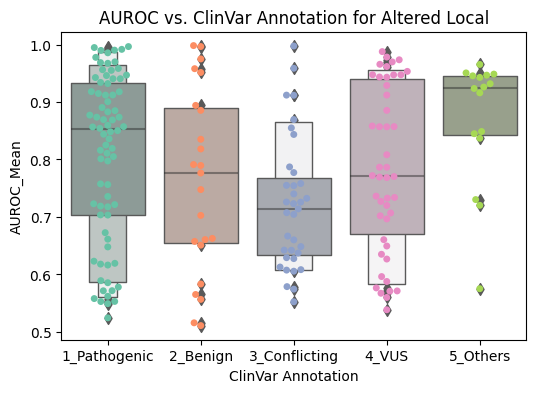

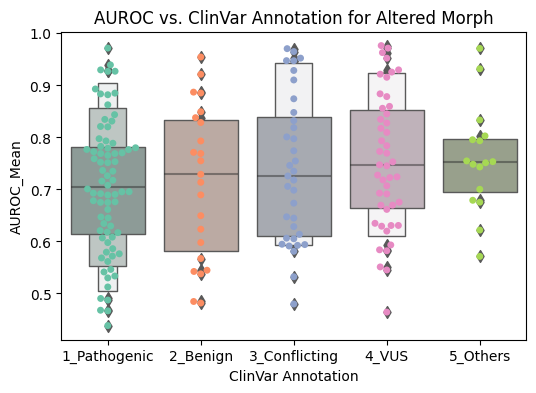

In [25]:
for change_summary in [f for f in os.listdir(OUTPUT_DIR) if f.startswith("altered")]:
    change_summary_df = pl.read_csv(os.path.join(OUTPUT_DIR, change_summary))
    fig, ax = plt.subplots(figsize=(6, 4))
    sns.boxenplot(data=var_scores.join(change_summary_df, on=["allele_0"], how="left").to_pandas(), palette="Set2", saturation=.15,
                  x="clinvar_clnsig_clean_dbnsfp_ai", y="AUROC_Mean", ax=ax, order=sorted(var_scores["clinvar_clnsig_clean_dbnsfp_ai"].drop_nulls().unique()))
    sns.swarmplot(data=var_scores.join(change_summary_df, on=["allele_0"], how="left").to_pandas(), palette="Set2", 
                  x="clinvar_clnsig_clean_dbnsfp_ai", y="AUROC_Mean", ax=ax, order=sorted(var_scores["clinvar_clnsig_clean_dbnsfp_ai"].drop_nulls().unique()))
    ax.set_xlabel("ClinVar Annotation")
    ax.set_title(f"AUROC vs. ClinVar Annotation for Altered {change_summary.split('_')[1].capitalize()}")